In [2]:
#import the libraries
%matplotlib inline 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import numpy as np 
from sklearn.metrics import confusion_matrix
import time 
from datetime import timedelta
import math

/Users/hamsinisankaran/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
tf.__version__

'1.4.1'

In [4]:
# Configuration of the convolution neural network 
#convolution layer 1
filter_size1 = 5 # convolution filter are 5 * 5 
num_filters1 = 16 # There are 16 of these filters 

#convolution layer 2 
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36         #  36 of these filters.

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Load the MNIST Dataset 

In [5]:
# MNIST dataset has 70000 images and associated labels. Training and testing sets are used 
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [7]:
# Each class label is a vector with 10 elements, all of which are zero, except for one element. Index of the 
# element is the digit. Class numbers of the test set are calculated
data.test.cls = np.argmax(data.test.labels, axis=1)


In [8]:
# Define the dimensions of the data

#MNIST images are 28 pixels in each dimension.
img_size = 28

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes, one class for each of 10 digits.
num_classes = 10

In [9]:
# A helper function for plotting the images are calculated. This function plots the 9 images in a 3*3 grid. 
#The true and the predicted classes of the images are written 

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
     
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])
        
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # The plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()
            

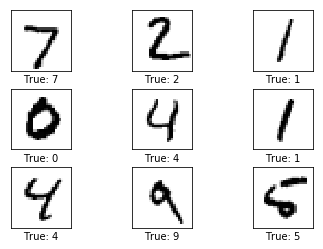

In [10]:
#Getting the first images on the test set 
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)


In [11]:
#helper functions for creating new variables 
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))
        

In [12]:
# Fuction to create a New convolution layer
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.
    
    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)
    
    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')
    
    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases
    
    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')
    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer) 
    
    
    return layer, weights
        


In [13]:
# reducing the 4 diensional tensor into 2 dimensional tensor , 
#since the fully connected layer needs 2 dimensioanl tensor
# as the input 

def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()
    
    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    layer_flat = tf.reshape(layer, [-1, num_features])
    
    # The shape of the flattened layer is now:
    #[num_images, img_height * img_width * num_channels]

    #Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [14]:
# Function for creating a new fully connected layer 
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [15]:
# define placehoder variables
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [16]:
# 4 dimension inputis needed for convolution neural network
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [17]:
#placeholder variables of the true class labels 
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [18]:
#cacluation of class numbr using argmax 
y_true_cls = tf.argmax(y_true, axis=1)

In [19]:
# creation of convolution layer 1 network and the images are downsampled.
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [20]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [21]:
#create convolution network layer 2 
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [22]:
#checking the shape of the tensor and the question mark indicates , there can be arbitrary number of images
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [23]:
#creation of flatten layer
layer_flat, num_features = flatten_layer(layer_conv2)


In [24]:
layer_flat 

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [33]:
num_features

1764

In [25]:
#addition of a fully connected layer to the network 
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [36]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [26]:
#creation of the last fully connected layer for predicting the class the image belongs to 
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [27]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [28]:
#using softmax function  to normalize them so that each element is limited between 
#zero and one and the 10 elements sum to one.
y_pred = tf.nn.softmax(layer_fc2)

In [29]:
#class number is the index of the largest element 
y_pred_cls = tf.argmax(y_pred, axis=1)

In [30]:
# appliying cross entropy to minimize the error between the actual and the predicted values 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

In [31]:
# average of cross entropy is calculated inorder to reduce to a single scalar value
cost = tf.reduce_mean(cross_entropy)

In [32]:
#adam optimizer method for optimization 
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

In [33]:
#vector of boolean , where the predicted class equals true class of image 
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [34]:
#vector of boolean is converted into float values 
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [35]:
#create tensorflow session 
session = tf.Session()

In [36]:
#initializing the weights and biases
session.run(tf.global_variables_initializer())

In [37]:
#performing optimization iteration
train_batch_size = 64

In [38]:
# Counter for total number of iterations performed so far.
total_iterations = 0
#Function for performing a number of optimization iterations so 
#as to gradually improve the variables of the network layers.
def optimize(num_iterations):
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    for i in range(total_iterations,
                   total_iterations + num_iterations):

    # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        #  The batch is put into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        
        
        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Printing the message.
            print(msg.format(i + 1, acc))
            
             # Update the total number of iterations performed.
    total_iterations += num_iterations
    
     # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time
    
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [39]:
# function to plot the errors 
def plot_example_errors(cls_pred, correct):
    
     # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    
    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

                             

In [40]:
#helper function to plot the confusion matrix 
def plot_confusion_matrix(cls_pred):
    
    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Plot the confusion matrix as an image.
    plt.matshow(cm)
    
    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

In [49]:
# helper function for showing performance 
# Split the test-set into smaller batches of this size.
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

# Number of images in the test-set.
    num_test = len(data.test.images)
    
# Allocate an array for the predicted classes which
# will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)
    
    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # The starting index for the next batch is denoted i.
    i = 0
    
    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

         # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]
        
        
        # Get the associated labels.
        labels = data.test.labels[i:j, :]
        
        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
        # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls
    
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    
     # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()
    
     # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test
    
    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))
    
    # Plot some examples of mis-classifications
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)
    
    
    

In [50]:
#printing the test accuracy 
print_test_accuracy()

Accuracy on Test-Set: 93.4% (9341 / 10000)


In [51]:
#performance after 1 optimization iteration 
optimize(num_iterations=1)

Optimization Iteration:   1001, Training Accuracy:  90.6%
Time usage: 0:00:00


In [52]:
print_test_accuracy()

Accuracy on Test-Set: 93.4% (9342 / 10000)


In [53]:
optimize(num_iterations=99) # performing 99 iterations 

Time usage: 0:00:08


Accuracy on Test-Set: 93.3% (9326 / 10000)
Example errors:


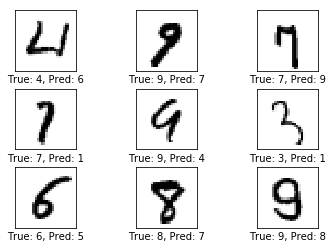

In [54]:
print_test_accuracy(show_example_errors=True)

In [55]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:   1101, Training Accuracy:  98.4%
Optimization Iteration:   1201, Training Accuracy:  98.4%
Optimization Iteration:   1301, Training Accuracy:  93.8%
Optimization Iteration:   1401, Training Accuracy:  95.3%
Optimization Iteration:   1501, Training Accuracy:  92.2%
Optimization Iteration:   1601, Training Accuracy:  98.4%
Optimization Iteration:   1701, Training Accuracy:  96.9%
Optimization Iteration:   1801, Training Accuracy:  96.9%
Optimization Iteration:   1901, Training Accuracy:  89.1%
Time usage: 0:01:12


Accuracy on Test-Set: 95.7% (9567 / 10000)
Example errors:


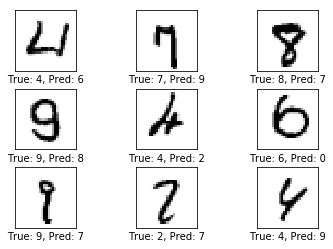

In [56]:
print_test_accuracy(show_example_errors=True)

In [57]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   2001, Training Accuracy:  95.3%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy:  98.4%
Optimization Iteration:   2301, Training Accuracy:  96.9%
Optimization Iteration:   2401, Training Accuracy:  93.8%
Optimization Iteration:   2501, Training Accuracy:  92.2%
Optimization Iteration:   2601, Training Accuracy:  95.3%
Optimization Iteration:   2701, Training Accuracy:  96.9%
Optimization Iteration:   2801, Training Accuracy:  96.9%
Optimization Iteration:   2901, Training Accuracy:  98.4%
Optimization Iteration:   3001, Training Accuracy: 100.0%
Optimization Iteration:   3101, Training Accuracy:  98.4%
Optimization Iteration:   3201, Training Accuracy:  96.9%
Optimization Iteration:   3301, Training Accuracy:  95.3%
Optimization Iteration:   3401, Training Accuracy: 100.0%
Optimization Iteration:   3501, Training Accuracy:  96.9%
Optimization Iteration:   3601, Training Accuracy:  96.9%
Optimization I

Accuracy on Test-Set: 98.8% (9876 / 10000)
Example errors:


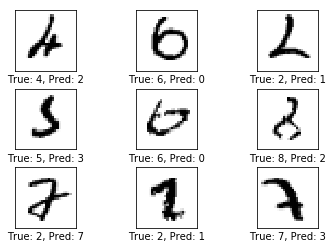

Confusion Matrix:
[[ 975    0    1    0    0    0    0    1    3    0]
 [   0 1131    1    0    0    1    1    0    1    0]
 [   1    4 1021    1    1    0    0    2    2    0]
 [   1    0    0 1003    0    1    0    3    2    0]
 [   0    0    2    0  974    0    0    1    1    4]
 [   2    0    0    7    0  880    1    0    1    1]
 [   6    2    0    0    3    6  940    0    1    0]
 [   0    3    7    1    0    0    0 1014    0    3]
 [   3    0    3    2    1    2    1    2  958    2]
 [   4    5    1    4    8    2    0    5    0  980]]


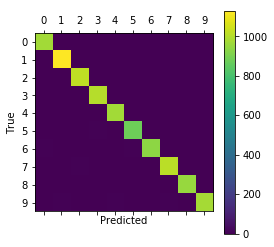

In [58]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)